## Homework 2

### Fully connected on STL10

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from IPython import display

torch.manual_seed(2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: {}'.format(device))


def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    
def get_params_num(net):
    return sum(map(torch.numel, net.parameters()))

    
def get_accuracy(dataloader, model, device='cpu'):
    tot = len(dataloader.dataset)
    with torch.no_grad():
        n_right = 0
        for data in dataloader:
            batch = data[0].to(device)
            labels = data[1].to(device)
            
            outputs = model(batch)
            out_labels = torch.argmax(outputs, dim=1)
            n_right += torch.sum(labels == out_labels)
    return float(n_right) / tot

Device: cpu


In [22]:
# import STL10
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.75, 0.75, 0.75), (0.75, 0.75, 0.75))])

trainset = torchvision.datasets.STL10(root='./data', split='train',
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.STL10(root='./data', split='train',
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset,batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'bird', 'car', 'cat',
           'deer', 'dog', 'horse', 'monkey', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


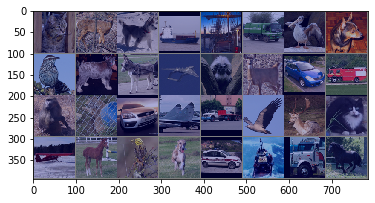

  cat  deer   dog  ship  ship truck  bird   dog  bird   dog horse plane monkey  deer   car truck monkey   cat   car plane truck  bird  deer   cat plane horse  bird   dog   car  ship truck horse


In [21]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(32)))

In [23]:
print(trainset)

Dataset STL10
    Number of datapoints: 5000
    Root location: ./data
    Split: train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.75, 0.75, 0.75), std=(0.75, 0.75, 0.75))
           )


In [24]:
print("trainset.data type: {}".format(type(trainset.data)))
print("CIFAR images shape: {}".format(tuple(trainset[0][0].shape)))

trainset.data type: <class 'numpy.ndarray'>
CIFAR images shape: (3, 96, 96)


In [33]:
#create a new Module object
class FCnn(nn.Module):
    def __init__(self):
        super(FCnn, self).__init__()
        self.input_dim = 3 * 96 * 96
        self.n_classes = 10
        #I use 4 linear layers
        self.fc1 = nn.Linear(self.input_dim, 300)
        self.fc2 = nn.Linear(300, 300)
        self.fc3=nn.Linear(300,300)
        self.out = nn.Linear(300, self.n_classes)
    
    def forward(self, x):
        #forward computation
        x = x.view(-1, self.input_dim) 
        #relu method
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)
        return x
        
net = FCnn()
net.to(device)
print("# of parameters: {}".format(get_params_num(net)))
print(net)

# of parameters: 8478310
FCnn(
  (fc1): Linear(in_features=27648, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=300, bias=True)
  (out): Linear(in_features=300, out_features=10, bias=True)
)


In [34]:
net.state_dict()

OrderedDict([('fc1.weight',
              tensor([[-0.0038,  0.0035,  0.0047,  ...,  0.0058,  0.0018, -0.0035],
                      [ 0.0041, -0.0009,  0.0026,  ..., -0.0026, -0.0035,  0.0049],
                      [-0.0027,  0.0009,  0.0047,  ...,  0.0049, -0.0011, -0.0014],
                      ...,
                      [ 0.0060, -0.0055, -0.0057,  ...,  0.0006, -0.0029, -0.0026],
                      [ 0.0034, -0.0014, -0.0008,  ..., -0.0024, -0.0035,  0.0046],
                      [ 0.0015, -0.0015, -0.0015,  ..., -0.0011,  0.0024,  0.0003]])),
             ('fc1.bias',
              tensor([ 1.9846e-03,  4.3993e-03,  1.4987e-03, -4.3066e-04, -3.9156e-03,
                       1.8028e-03,  5.8397e-04,  3.7184e-03,  3.8191e-03, -2.5925e-03,
                      -5.2469e-03,  3.5023e-03, -5.9844e-03,  2.2786e-04, -1.3244e-03,
                       5.3258e-03, -2.7906e-03,  3.4020e-04, -4.4185e-03, -5.0862e-03,
                      -7.0861e-04,  5.1396e-03, -4.0914e-03, -4.

In [41]:
#I define the learning rate
lr = 0.02

criterion = nn.CrossEntropyLoss()
#I use Avarage Stochastic Gradient Descent
optimizer = optim.ASGD(net.parameters(), lr=lr, weight_decay=1e-5)

In [42]:
epochs = 10

#I run this over 10 epochs
n_batches = len(trainloader)
for e in range(epochs):
    for i, data in enumerate(trainloader):
        batch = data[0].to(device)
        labels = data[1].to(device)      
        outputs = net(batch)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print("[EPOCH]: {}, [BATCH]: {}/{}, [LOSS]: {}".format(e, i, n_batches, loss.item()))
            display.clear_output(wait=True)

[EPOCH]: 9, [BATCH]: 150/157, [LOSS]: 0.4887734651565552


In [43]:

acc_train = get_accuracy(trainloader, net, device=device)
acc_test = get_accuracy(testloader, net, device=device)
print("Train accuracy: {}\nTest accuracy: {}".format(acc_train, acc_test))
#Good performance

Train accuracy: 0.7688
Test accuracy: 0.7688
